In [1]:
%matplotlib inline
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import os
from glob import glob
import numpy as np
from matplotlib import pyplot
import helper
show_n_images = 25

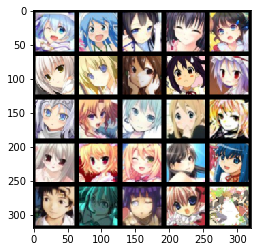

In [2]:
anime_images = helper.get_batch(glob('faces/*.jpg')[:show_n_images], 64, 64, 'RGB')
pyplot.imshow(helper.images_square_grid(anime_images, 'RGB'))

In [3]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


In [4]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], 'real_input_images')
    input_z = tf.placeholder(tf.float32, [None, z_dim], 'input_z')
    learning_rate = tf.placeholder(tf.float32, [], 'learning_rate')
    return real_input_images, input_z, learning_rate


In [5]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xn
        # Convolutional layer, 14x14x64
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob)
        
        # Strided convolutional layer, 7x7x128
        conv2 = tf.layers.conv2d(drop1, 128, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob)
        
        # Strided convolutional layer, 4x4x256
        conv3 = tf.layers.conv2d(drop2, 256, 5, 2, 'same', use_bias=False)
        bn3 = tf.layers.batch_normalization(conv3)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(lrelu3, keep_prob)
        
        # fully connected
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer, 4x4x1024
        fc = tf.layers.dense(z, 4*4*1024, use_bias=False)
        fc = tf.reshape(fc, (-1, 4, 4, 1024))
        bn0 = tf.layers.batch_normalization(fc, training=is_train)
        lrelu0 = tf.maximum(alpha * bn0, bn0)
        drop0 = tf.layers.dropout(lrelu0, keep_prob, training=is_train)
        
        # Deconvolution, 7x7x512
        conv1 = tf.layers.conv2d_transpose(drop0, 512, 4, 1, 'valid', use_bias=False)
        bn1 = tf.layers.batch_normalization(conv1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob, training=is_train)
        
        # Deconvolution, 14x14x256
        conv2 = tf.layers.conv2d_transpose(drop1, 256, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob, training=is_train)
        
        # Output layer, 28x28xn
        logits = tf.layers.conv2d_transpose(drop2, out_channel_dim, 5, 2, 'same')
        
        out = tf.tanh(logits)
        
        return out

In [7]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth_factor=0.1):
    
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1 - smooth_factor)))
    
    input_fake = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss_real + d_loss_fake, g_loss

In [8]:

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


In [9]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    #pyplot.imshow(images_grid, cmap=cmap)
    #pyplot.show()
    return images_grid

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    
    steps = 0
    count = 0
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
         
         # continue training
        save_path = saver.save(sess, "/tmp/model.ckpt")
        ckpt = tf.train.latest_checkpoint('./model/')
        saver.restore(sess, save_path)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        #sess.run(tf.global_variables_initializer())
        os.mkdir('output')
        for epoch_i in range(epoch_count):
            os.mkdir('output/'+ str(epoch_i))
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses for viewing after training
                    #losses.append((train_loss_d, train_loss_g))
                     

                if steps % show_every == 0:
                    count = count +1
                    iterr = count*show_every
                    # Show example output for the generator
                    images_grid = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    dst = os.path.join("output", str(epoch_i), str(iterr)+".png")
                    pyplot.imsave(dst, images_grid)
                    
                 # saving the model         
                if epoch_i % 10 == 0:
                    if not os.path.exists('./model/'):
                        os.makedirs('./model')
                    saver.save(sess, './model/' + str(epoch_i))

In [11]:
batch_size = 16
z_dim = 100
learning_rate = 0.00025
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 100

anime_faces = helper.Dataset(64, 64, glob(os.path.join('faces/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, anime_faces.get_batches,
          anime_faces.shape, anime_faces.image_mode)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Epoch 1/100 Step 10... Dis

KeyboardInterrupt: 